# HW 4
#### - Serat Saad

The following cell includes all the necessary libraries that we might need for the image reduction.

In [1]:
# Importing the necessary libraries

import seaborn as sns
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import ccdproc
from astropy.nddata import CCDData
from ccdproc import subtract_overscan, trim_image, combine
from astropy.visualization import hist
from astropy.modeling import models


### File Reviewing in DS 9 and saving headers
Total rows 2048, total columns 2200.

After reviewing the bias images, dark images, and flats in DS9, we can conlcude that first 54 column (column 0 to 54) and last 95 columns (index 2105 to 2200) are the columns for overscan regions (biassec). The rest of the columns are for trimsec.

In the following cell, I opened a new reduced directory and saved new header for each of the files. Took me some while to make a function that will work for all the files.

In [2]:
data_dir = "Imaging/"
reduced_dir = "Imaging_reduced/"

In [3]:
def modify_headers_and_save(files_list, image_type, object_name, data_directory, reduced_directory, filter_name=None):

    hdus = []
    for file in files_list:
        try:
            hdus.append(fits.open(data_directory + file))
        except FileNotFoundError:
            print(f"File {file} not found.")
            continue
    
    hdrs = [hdu[0].header for hdu in hdus]
    
    for idx, hdr in enumerate(hdrs):
        hdr['imagetyp'] = image_type
        hdr['object'] = object_name
        hdr['biassec'] = '[0:2048,2105:2200]'
        hdr['trimsec'] = '[0:2048,54:2105]'
        if filter_name:
            hdr['filter'] = filter_name[idx]
        
        hdus[idx].writeto(reduced_directory + files_list[idx], overwrite=True)
    
    del hdus, hdrs


# Process bias files
bias_files = [f'a{str(i).zfill(3)}.fits' for i in range(93, 112)]
modify_headers_and_save(bias_files, 'bias', 'none', data_dir, reduced_dir)

# Process flat files
flat_files = [f'a{str(i).zfill(3)}.fits' for i in range(5, 63)]
filter_sequence_flat = ['U']*7 + ['B']*7 + ['V']*7 + ['R']*7 + ['I']*7 + ['Ha']*(len(flat_files) - 35)
modify_headers_and_save(flat_files, 'skyflat', 'none', data_dir, reduced_dir, filter_sequence_flat)

# Process other files
other_files = [f'a{str(i).zfill(3)}.fits' for i in range(74, 247)]
# Remove specified indices
indices_to_remove = list(range(19, 56)) + list(range(29, 91)) + list(range(39, 64))
for index in sorted(indices_to_remove, reverse=True):
    del other_files[index]

filter_sequence_other = ['V']*7 + ['U']*2 + ['B']*3 + ['V']*3 + ['R']*3 + ['I']*3 + ['Ha']*2
filter_sequence_other += filter_sequence_other + ['Ha']
modify_headers_and_save(other_files, 'science', 'pg1633', data_dir, reduced_dir, filter_sequence_other)

# Process dark files
dark_files = [f'd{str(i).zfill(3)}.fits' for i in range(1, 16)]
modify_headers_and_save(dark_files, 'dark', 'none', data_dir, reduced_dir)


File a221.fits not found.
File a222.fits not found.
File a223.fits not found.
File a224.fits not found.
File a225.fits not found.
File a226.fits not found.
File a227.fits not found.
File a228.fits not found.
File a229.fits not found.
File a230.fits not found.
File a231.fits not found.
File a232.fits not found.
File a233.fits not found.
File a234.fits not found.
File a235.fits not found.
File a236.fits not found.


### Plotting and finding RMS and mean:

In the following cell I defined a function that can be used to plot an image and find its RMS and mean value. We choose file a165.fits. According to the log file and its header, it's the image of M16. This will act as an example of how we can plot the images and find their mean and standard deviations.

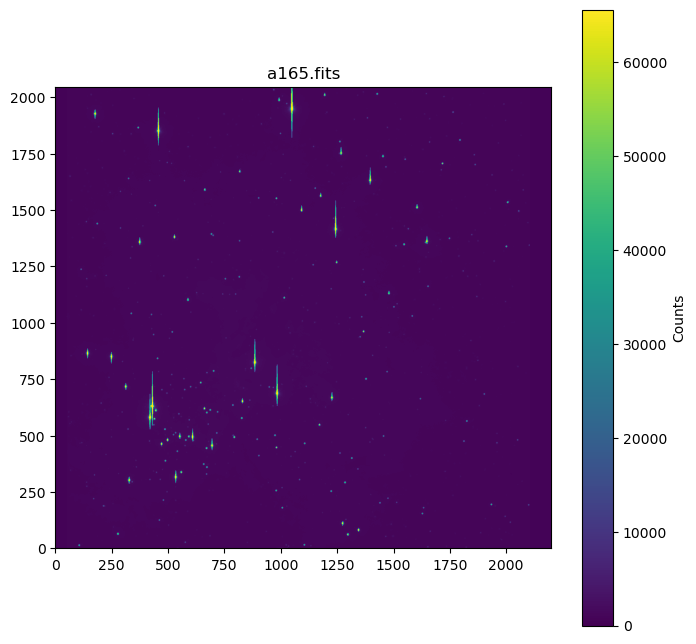

Mean value of the image: 1218.6483975497158
RMS value of the image: 3095.548108294022


In [4]:
def plot_fits_image(file_path, figsize=(8, 8)):

    # Loading the FITS file
    with fits.open(file_path) as hdul:
        data = hdul[0].data
    
    # Calculating the mean and RMS values
    mean_value = np.mean(data)
    rms_value = np.std(data)
    
    # Using file name as the title
    title = file_path.split('/')[-1]
    
    # Visualizing the image
    plt.figure(figsize=figsize)
    plt.imshow(data, origin='lower')
    plt.colorbar(label='Counts')
    plt.title(title)
    plt.show()
    
    # Printing the mean and RMS values
    print(f"Mean value of the image: {mean_value}")
    print(f"RMS value of the image: {rms_value}")


plot_fits_image('Imaging_reduced/a165.fits')


Now we can start working with a bias image. A bias image can be helpful to start our process of data reduction.

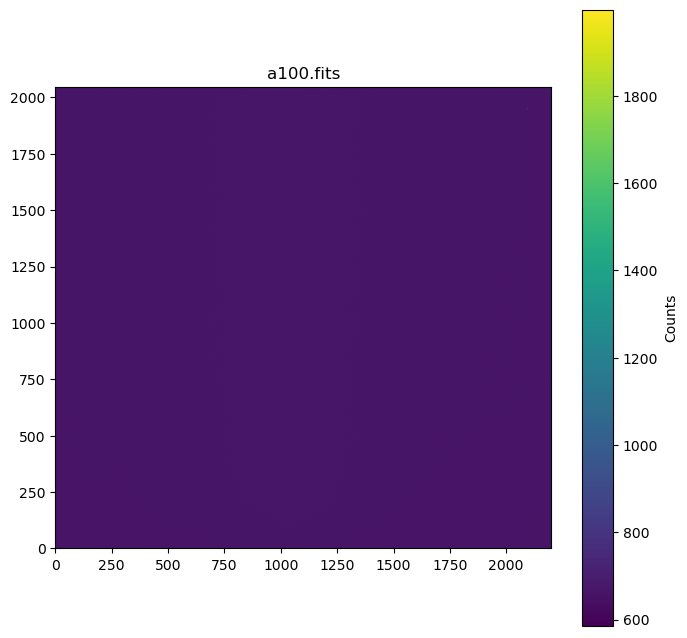

Mean value of the image: 665.5508478338069
RMS value of the image: 8.941481808818256


In [5]:
plot_fits_image('Imaging_reduced/a100.fits')


### Other plotting

Now we can plot a single row and a single comlumn of the bias image to see how it behaves. I hae formed a function that will plot the rows and columns (the plot should be number of pixel counts in y axis and row or column number in x axis.)

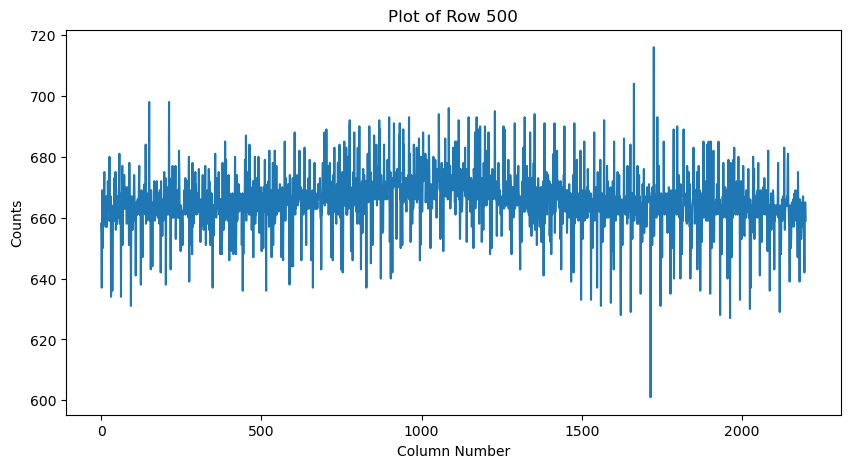

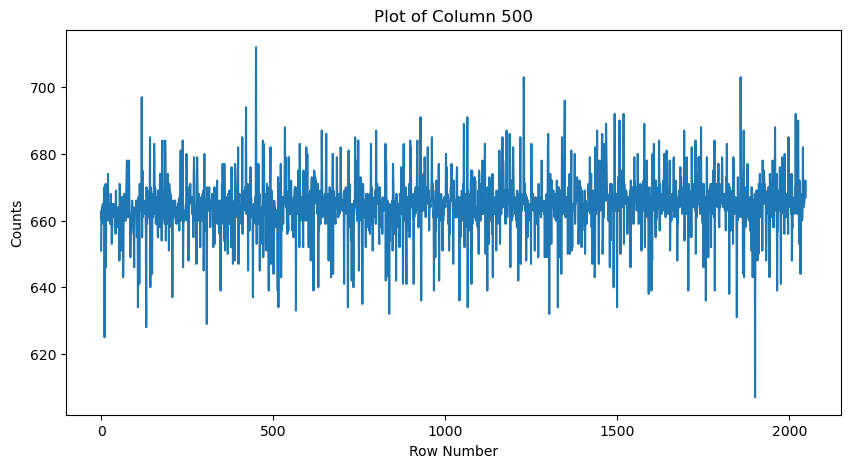

In [6]:
def plot_fits_row_col(file_path, row_num, col_num):
    # Loading the FITS file
    with fits.open(file_path) as hdul:
        data = hdul[0].data
    
    # Plotting the specified row
    plt.figure(figsize=(10, 5))
    plt.plot(data[row_num, :])
    plt.title(f'Plot of Row {row_num}')
    plt.xlabel('Column Number')
    plt.ylabel('Counts')
    plt.show()
    
    # Plotting the specified column
    plt.figure(figsize=(10, 5))
    plt.plot(data[:, col_num])
    plt.title(f'Plot of Column {col_num}')
    plt.xlabel('Row Number')
    plt.ylabel('Counts')
    plt.show()


plot_fits_row_col('Imaging_reduced/a100.fits', 500, 500)



Then we can fix a center region of the bias image to get the mean and RMS value of that region.

In [7]:
def center_region_stats(file_path, region_size=100):
    
    # Loading the FITS file
    with fits.open(file_path) as hdul:
        data = hdul[0].data
    
    # Getting the center coordinates
    center_x, center_y = data.shape[1] // 2, data.shape[0] // 2
    
    # Defining the center region
    start_x, end_x = center_x - region_size // 2, center_x + region_size // 2
    start_y, end_y = center_y - region_size // 2, center_y + region_size // 2
    center_region = data[start_y:end_y, start_x:end_x]
    
    # Calculating mean and RMS values
    mean_value = np.mean(center_region)
    rms_value = np.std(center_region)

    print(f"Mean value of the center region: {mean_value}")
    print(f"RMS value of the center region: {rms_value}")


center_region_stats('Imaging_reduced/a100.fits')


Mean value of the center region: 670.9281
RMS value of the center region: 8.778344399144977


## Dealing with the bias file and creating a master bias

Now we can look for the distribution of mean values for the bias files and for all the other files. Having a function might not be helpful in this case.

C:\Users\serat\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\serat\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


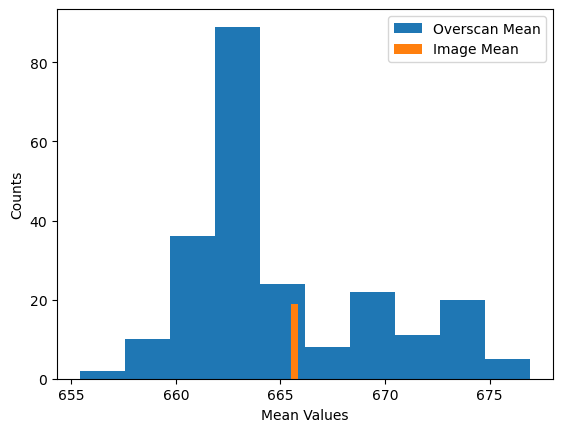

In [8]:
# Calculating the mean values for each bias image
data_list = []

bias_files = ['a' + str(i).zfill(3) + '.fits' for i in np.arange(19) + 93]

for file in bias_files:
    with fits.open(f"Imaging_reduced/{file}") as hdul:
        data_list.append(hdul[0].data)

mean_levels = [np.mean(data) for data in data_list]

# Extracting overscan regions and calculate their mean
other_data_list = []

other_files = ['a' + str(i).zfill(3) + '.fits' for i in range(5, 221)]

indices_to_remove = [135, 136, 147, 159, 177, 188]

other_files = [file for index, file in enumerate(other_files) if index not in indices_to_remove]

for file in other_files:
    with fits.open(f"Imaging/{file}") as hdul:
        data_list.append(hdul[0].data)

overscan_means = []

for data in data_list:
    overscan_region = data[0:2048, 2105:2200]
    overscan_means.append(np.mean(overscan_region))

# Filtering out extreme values from the overscan means
a = np.where((np.array(overscan_means) < 700.0) & (np.array(overscan_means) > 600.0))
overscan_means = np.array(overscan_means)[a]

# Plotting histograms to compare distributions of mean values
plt.hist(overscan_means)
plt.hist(mean_levels, bins=1)
plt.legend(["Overscan Mean", "Image Mean"])
plt.xlabel("Mean Values")
plt.ylabel("Counts")
plt.show()


From the plot we can see that the mean pixel value of the bias images has a very short range and lies almost within the same region. But the pixel value for the overscan region is more distributed. So , it might be a good idea to select the overscan region.

We can also compute the variation throughout the night through calculating their standard deviation. If the standard deviation is higher, it will mean that the variation is higher and vice versa.

In [9]:
# Compute variations
bias_variation = np.std(mean_levels)
overscan_variation = np.std(overscan_means)

print(f"Bias Level Variation throughout the night: {bias_variation}")
print(f"Overscan Region Variation throughout the night: {overscan_variation}")

Bias Level Variation throughout the night: 0.07031574977632397
Overscan Region Variation throughout the night: 4.564421103199964


So, it's clear that the bias level variation is much lower than the overscan region variation.

We need take the overscan region and plot different polynomials to see which one is the best.

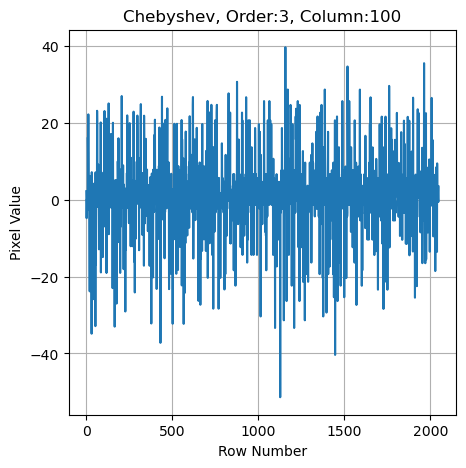

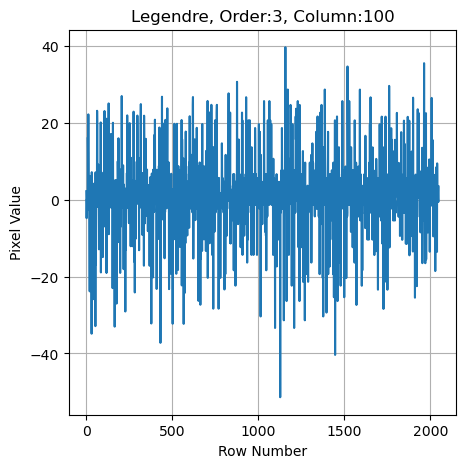

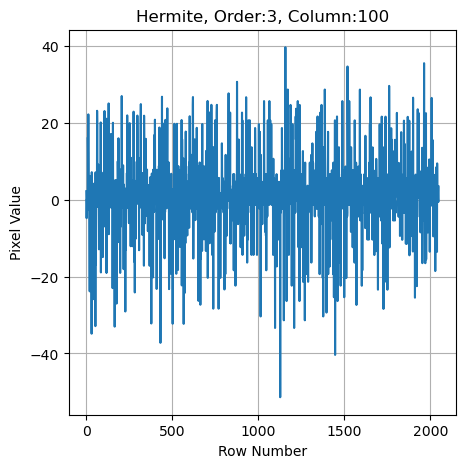

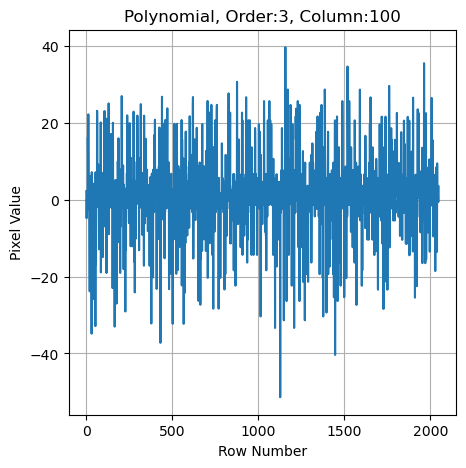

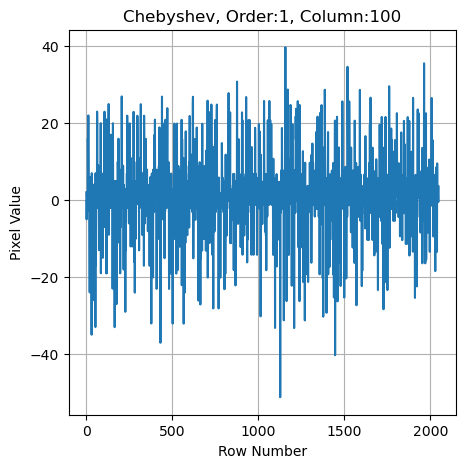

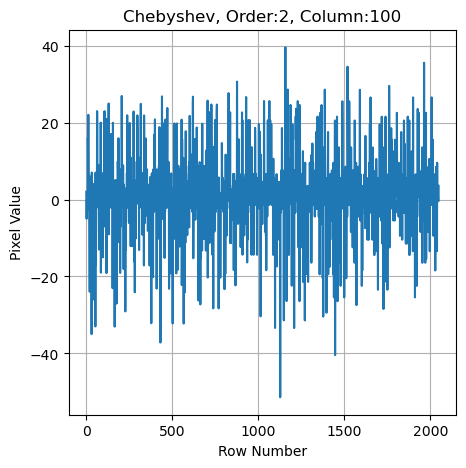

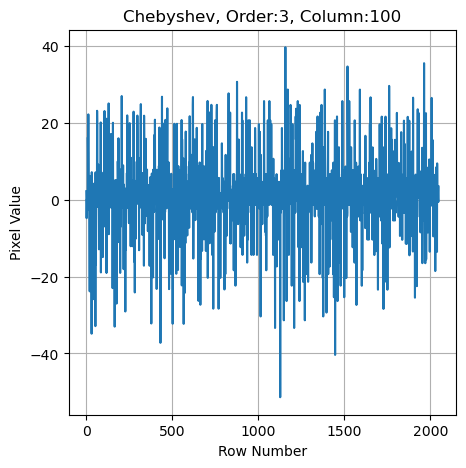

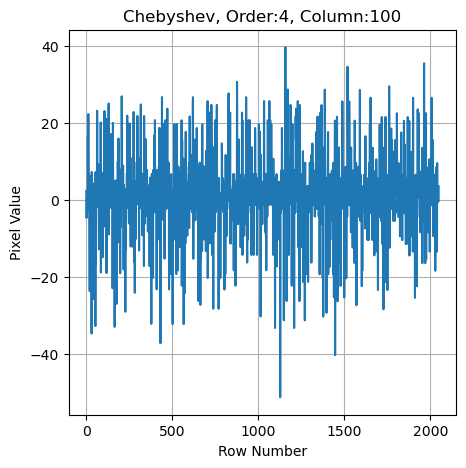

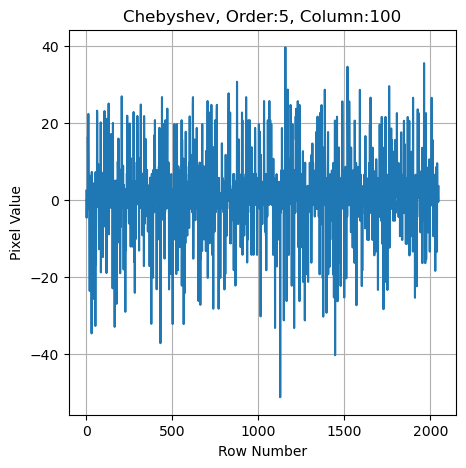

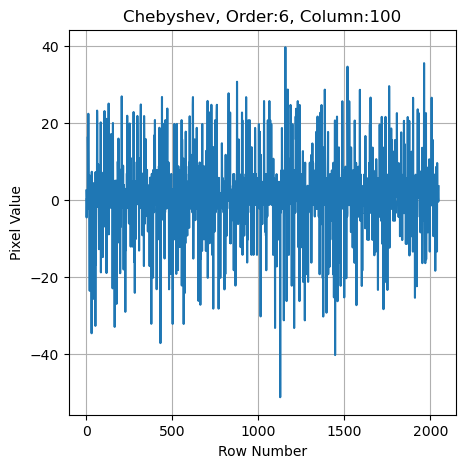

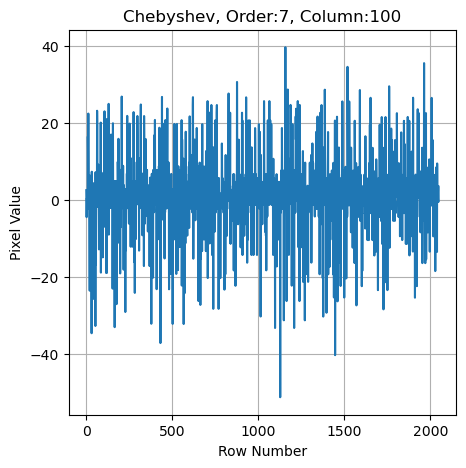

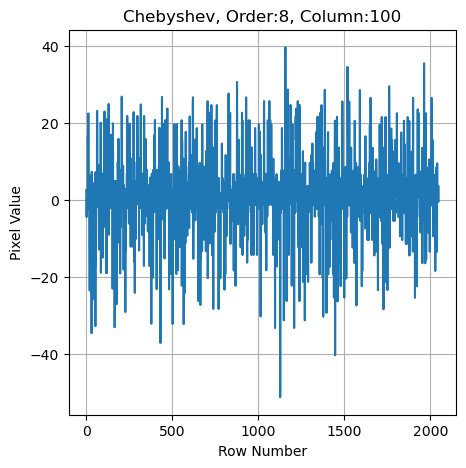

In [10]:
def process_image(img_path, overscan_axis, overscan_region1, overscan_region2, poly_type, poly_order):
    """
    Parameters:
    - img_path (str): Path to the FITS image.
    - overscan_axis (int): Axis along which the overscan is present (0 for rows, 1 for columns).
    - overscan_region1 (slice): Slice specifying the first overscan region.
    - overscan_region2 (slice): Slice specifying the second overscan region.
    - poly_type (str): Type of polynomial for fitting.
    - poly_order (int): Order of polynomial for fitting.

    Returns:
    - CCDData: Processed image.
    """
    # Loading the image
    ccd = CCDData.read(img_path, unit="adu")

    # Defining the polynomial model
    if poly_type == 'chebyshev':
        poly_model = models.Chebyshev1D(degree=poly_order)
    elif poly_type == 'legendre':
        poly_model = models.Legendre1D(degree=poly_order)
    elif poly_type == 'hermite':
        poly_model = models.Hermite1D(degree=poly_order)
    else:
        poly_model = models.Polynomial1D(degree=poly_order)

    # Subtracting overscan
    ccd = ccdproc.subtract_overscan(ccd, 
                                    overscan_axis=overscan_axis, 
                                    overscan=ccd[:, overscan_region1], 
                                    model=poly_model)
    ccd = ccdproc.subtract_overscan(ccd, 
                                    overscan_axis=overscan_axis, 
                                    overscan=ccd[:, overscan_region2], 
                                    model=poly_model)

    # Trimming the image
    trimmed_ccd = ccdproc.trim_image(ccd[:, overscan_region1.stop:overscan_region2.start])

    return trimmed_ccd

def display_processed_image_row(file, overscan_axis, overscan_region_left, overscan_region_right, poly_type, poly_order, column_number):
    img_path = f"Imaging/{file}"
    processed_img = process_image(img_path, overscan_axis, overscan_region_left, overscan_region_right, poly_type, poly_order)

    # Extracting the pixel values for the specified column
    column_data = processed_img.data[:, column_number]
    
    # Creating an array of row numbers
    row_numbers = np.arange(column_data.size)

    # Displaying the plot
    plt.figure(figsize=(5, 5))
    plt.plot(row_numbers, column_data)
    plt.xlabel('Row Number')
    plt.ylabel('Pixel Value')
    plt.title(f"{poly_type.capitalize()}, Order:{poly_order}, Column:{column_number}")
    plt.grid(True)
    plt.show()


file = "a100.fits"
column_number = 100  # Plotting for column number 100
polynomial_types = ['chebyshev', 'legendre', 'hermite', 'polynomial']
for poly_type in polynomial_types:
    display_processed_image_row(file, 1, slice(0, 54), slice(2104, 2200), poly_type, 3, column_number)

orders = range(1, 9)
for order in orders:
    display_processed_image_row(file, 1, slice(0, 54), slice(2104, 2200), 'chebyshev', order, column_number)


I got almost the same result for all the plots.

So, I think there's either they are all same, or maybe I did something wrong for which I got all of them same.

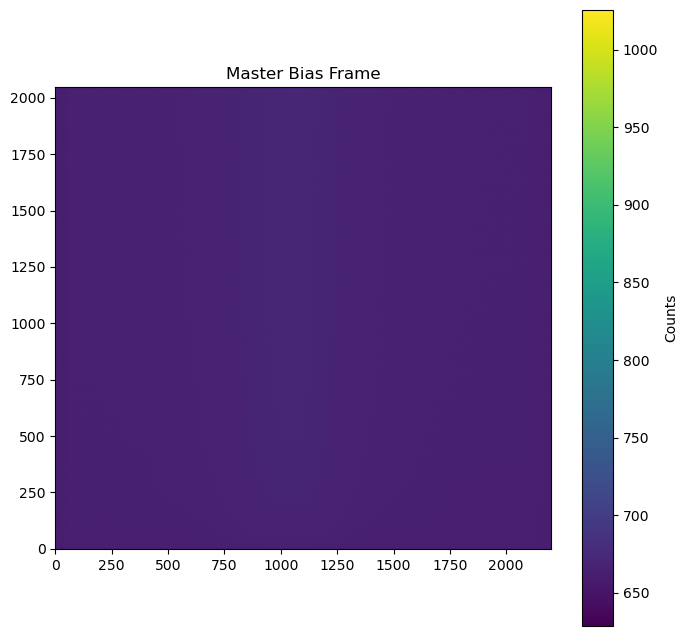

In [11]:
# Reading all bias frames and extract the data
data_dir = "Imaging_reduced/"  # Assuming the reduced bias frames are in this directory
bias_files = ['a'+str(i).zfill(3)+'.fits' for i in range(93, 112)]
data_list = []

for file in bias_files:
    with fits.open(data_dir + file) as hdul:
        data_list.append(hdul[0].data)

# Converting data arrays in data_list to CCDData objects
ccd_list = [CCDData(data, unit="adu") for data in data_list]

# Combining the CCDData objects to create a master bias
master_bias = combine(ccd_list, method='average')

# Visualizing the master bias
plt.figure(figsize=(8, 8))
plt.imshow(master_bias, origin='lower')
plt.colorbar(label='Counts')
plt.title('Master Bias Frame')
plt.show()


To compare the master bias frame with other bias frames, we can plot the historgram of the master bias frame over one of the bias frame and see how they allign with each other. But first we can create a function for that.

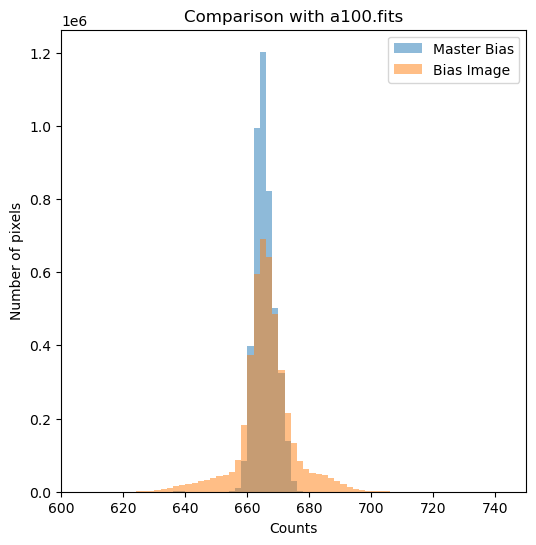

In [12]:
def compare_master_bias(bias_image_path, master_bias_data):
    # Loading the FITS file
    with fits.open(bias_image_path) as hdul:
        bias_data = hdul[0].data

    # Plotting the histogram
    bins = np.histogram_bin_edges(master_bias_data.flatten(), bins=100, range=[600, 800])
    plt.figure(figsize=(6, 6))
    plt.hist(master_bias_data.flatten(), bins=bins, alpha=0.5, label='Master Bias', rwidth=1)
    plt.hist(bias_data.flatten(), bins=bins, alpha=0.5, label='Bias Image', rwidth=1)
    plt.legend()
    plt.xlim([600, 750])
    plt.xlabel('Counts')
    plt.ylabel('Number of pixels')
    plt.title(f"Comparison with {bias_image_path.split('/')[-1]}")
    plt.show()

    return

# Comparing with bias image a100.fits
bias_image_path = 'Imaging_reduced/a100.fits'
compare_master_bias(bias_image_path, master_bias.data)


So, from this histogram it's clear that the master bias is definitely better because it has smaller range of values with a better distribution.

## Dealing with Dark Files and creating master dark


To deal with dark current, we can first calculate the dark current and use a threshold of 5 sigma to ignore the cosmic rays. Then we can find the range of the dark currents. We can start with defining a function.

In [13]:
def dark_current_range(dark_image_path, gain=2.5):
    # Loading the FITS file
    with fits.open(dark_image_path) as hdul:
        dark_data = hdul[0].data
        exposure_time = hdul[0].header['EXPTIME']

    # Calculating the dark current
    dark_current = (dark_data * gain) / exposure_time

    # Identifying cosmic rays using a threshold
    mean_dark_current = dark_current.mean()
    std_dark_current = dark_current.std()
    threshold = mean_dark_current + 5 * std_dark_current
    cosmic_ray_mask = dark_current > threshold

    # Masking out cosmic rays and calculating the range of dark current
    dark_current_no_cosmic = dark_current[~cosmic_ray_mask]
    min_dark_current = dark_current_no_cosmic.min()
    max_dark_current = dark_current_no_cosmic.max()

    return min_dark_current, max_dark_current


min_dc, max_dc = dark_current_range("Imaging/d001.fits")
print(f"Range of Dark Current: {min_dc:.2f} to {max_dc:.2f} electrons per pixel per second")

Range of Dark Current: 767.50 to 856.25 electrons per pixel per second


For the following step we will call all the dark files first and then I get the master dark for each of the methods.

In [14]:
dark_files = ['d' + str(i).zfill(3) + '.fits' for i in range(1, 16)]
ccd_list_dark = [CCDData.read(f"Imaging/{file}", unit="adu") for file in dark_files]


# Straight average of all dark frames
master_dark_avg = ccdproc.combine(ccd_list_dark, method='average')

# Straight median of all dark frames
master_dark_median = ccdproc.combine(ccd_list_dark, method='median')

# Average with sigma-clipping
master_dark_avg_clip = ccdproc.combine(ccd_list_dark, method='average', sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3)

# Median with sigma-clipping
master_dark_median_clip = ccdproc.combine(ccd_list_dark, method='median', sigma_clip=True, sigma_clip_low_thresh=3, sigma_clip_high_thresh=3)

One way to get the best master dark would be to compare their rms values.

In [15]:
rms_avg = np.sqrt(np.mean(master_dark_avg.data**2))
rms_median = np.sqrt(np.mean(master_dark_median.data**2))
rms_avg_clip = np.sqrt(np.mean(master_dark_avg_clip.data**2))
rms_median_clip = np.sqrt(np.mean(master_dark_median_clip.data**2))

print(f"RMS (average): {rms_avg}")
print(f"RMS (median): {rms_median}")
print(f"RMS (average with sigma-clipping): {rms_avg_clip}")
print(f"RMS (median with sigma-clipping): {rms_median_clip}")




RMS (average): 658.7035751462037
RMS (median): 658.7485962535043
RMS (average with sigma-clipping): 658.691635209901
RMS (median with sigma-clipping): 658.7496533346667


So, the best (or least) rms value is for the master dark calculated through the average with sigma clipping.

Now we can compare the noise in the master biase with the dark current.

In [16]:
dark_current_master = np.mean(master_dark_avg_clip.data)
noise_master_bias = np.std(master_bias.data)

# Finding the ratio
ratio = dark_current_master / noise_master_bias
print(f"Typical dark current is {ratio} times larger than the noise in the master image.")


Typical dark current is 202.1150392111679 times larger than the noise in the master image.
